In [ ]:
from pytorch_lightning import LightningModule
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
import torch.nn.functional as F
import numpy as np
import skimage


In [ ]:

import nni
import numpy as np
import skimage
import torch
import nni.retiarii.nn.pytorch as nn

from nni.retiarii import model_wrapper

from skimage.metrics import peak_signal_noise_ratio as skimage_psnr

from torch import cuda, optim, tensor, zeros_like
from torch import device as torch_device

from darts.common_utils import *
from darts.early_stop import EarlyStop, MSE, MAE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom, phantom_to_torch

# old

In [ ]:

def preprocess_image(resolution, noise_type, noise_factor, input_img_np=None):
    """
    Generates an image, adds noise, and converts it to both numpy and torch tensors.

    Args:
    - resolution (int): Resolution for the phantom image.
    - noise_type (str): Type of noise to add.
    - noise_factor (float): Noise factor.
    - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

    Returns:
    - img_np (numpy.ndarray): Original image in numpy format.
    - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
    - img_torch (torch.Tensor): Original image in torch tensor format.
    - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
    """
    if input_img_np is None:
        raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
    else:
        raw_img_np = input_img_np.copy()
        
    img_np = raw_img_np.copy() # 1x64x64 np array
    img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
    img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
    img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
    
    return img_np, img_noisy_np, img_torch, img_noisy_torch


def main_evaluation_with_closure(model_cls):
    device = torch_device('cuda' if cuda.is_available() else "cpu")
    dtype = cuda.FloatTensor if cuda.is_available() else torch.FloatTensor

    buffer_size = 100
    patience = 600
    num_iter = 1200
    show_every = 1
    lr = 0.00005

    reg_noise_std = tensor(1./30.).type(dtype).to(device)
    noise_type = 'gaussian'
    noise_factor = 0.1
    resolution= 6
    n_channels = 1

    img_np, _, _, img_noisy_torch = preprocess_image(resolution, noise_type, noise_factor)
    img_noisy_torch = img_noisy_torch.to(device)
    net_input = get_noise(input_depth=1, spatial_size=img_np.shape[1], noise_type=noise_type).type(dtype).to(device)

    # Add synthetic noise
    net = model_cls().to(device)
    net = net.type(dtype)

    # Loss
    criterion = nn.MSELoss().type(dtype).to(device)

    # Optimizer
    p = get_params('net', net, net_input)  # network parameters to be optimized
    optimizer = optim.Adam(p, lr=lr)

    # Optimize

    loss_history = []
    psnr_history = []
    ssim_history = []
    variance_history = []
    x_axis = []
    earlystop = EarlyStop(size=buffer_size,patience=patience)
    def closure(iterator):
        #DIP
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=reg_noise_std)
        r_img_torch = net(net_input_perturbed)
        total_loss = criterion(r_img_torch, img_noisy_torch)
        total_loss.backward()
        loss_history.append(total_loss.item())
        if iterator % show_every == 0:
            # evaluate recovered image (PSNR, SSIM)
            r_img_np = torch_to_np(r_img_torch)
            psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
            temp_img_np = np.transpose(img_np,(1,2,0))
            temp_r_img_np = np.transpose(r_img_np,(1,2,0))
            data_range = temp_img_np.max() - temp_img_np.min()
            if n_channels == 1:
                multichannel = False
            else:
                multichannel = True
            ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=multichannel, win_size=7, channel_axis=-1, data_range=data_range)
            psnr_history.append(psnr)
            ssim_history.append(ssim)
            
            #variance hisotry
            r_img_np = r_img_np.reshape(-1)
            earlystop.update_img_collection(r_img_np)
            img_collection = earlystop.get_img_collection()
            if iterator % (show_every*10) == 0:
                print(f'Iteration %05d    Loss %.4f' % (iterator, total_loss.item()) + '    PSNR %.4f' % (psnr) + '    SSIM %.4f' % (ssim))
                nni.report_intermediate_result(psnr)
            if len(img_collection) == buffer_size:
                ave_img = np.mean(img_collection,axis = 0)
                variance = []
                for tmp in img_collection:
                    variance.append(MSE(ave_img, tmp))
                cur_var = np.mean(variance)
                cur_epoch = iterator
                variance_history.append(cur_var)
                x_axis.append(cur_epoch)
                if earlystop.stop == False:
                    earlystop.stop = earlystop.check_stop(cur_var, cur_epoch)
        if earlystop.stop:
            # Report final PSNR to NNI
            nni.report_final_result(psnr)
            return "STOP"
        return total_loss, psnr
        
    for iterator in range(num_iter):
        optimizer.zero_grad()
        early_stop, psnr = closure(iterator)
        optimizer.step()

        if early_stop == "STOP":
            print("Early stopping triggered.")
            break
    
    if earlystop.stop != "STOP":
        nni.report_final_result(psnr)

# lightning

In [16]:
import nni
import numpy as np
import skimage
import torch
import nni.retiarii.nn.pytorch as nn

import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer   
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.utilities.types import STEP_OUTPUT # change to lightning.pytorch.utilities.types

from skimage.metrics import peak_signal_noise_ratio as skimage_psnr

from torch import optim, tensor, zeros_like
from typing import Any, Optional

from darts.common_utils import *
from darts.early_stop import EarlyStop, MSE, MAE
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset
from nni.retiarii.evaluator.pytorch.lightning import DataLoader

class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary)
        return self.image

class LightningEval(LightningModule):
    def __init__(self, model_cls, phantom=None, buffer_size=100, patience=600, num_iter=1200, show_every=1, 
                lr=0.00005, noise_type='gaussian', noise_factor=0.1, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super(LightningEval, self).__init__()

        # input
        self.phantom = phantom

        # Model
        self.net = model_cls.to(self.device)

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.buffer_size = buffer_size
        self.patience = patience
        self.num_iter = num_iter
        self.show_every = show_every
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        # History and early stopper
        self.loss_history = []
        self.psnr_history = []
        self.ssim_history = []
        self.variance_history = []
        self.x_axis = []
        self.earlystop = EarlyStop(size=self.buffer_size, patience=self.patience)
        
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.net(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping but it's not the same as the one used in the DIP repo)
        """        

        r_img_torch = self.forward(self.net_input)
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)

        # Using global_step to count iterations
        iterator = self.global_step

        self.loss_history.append(total_loss.item())

        if iterator % self.show_every == 0:
            # evaluate recovered image (PSNR, SSIM)
            r_img_np = torch_to_np(r_img_torch)
            psnr = skimage_psnr(self.img_np, r_img_np)
            temp_img_np = np.transpose(self.img_np, (1, 2, 0))
            temp_r_img_np = np.transpose(r_img_np, (1, 2, 0))
            data_range = temp_img_np.max() - temp_img_np.min()
            if self.n_channels == 1:
                multichannel = False
            else:
                multichannel = True
            ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=multichannel, win_size=7, channel_axis=-1, data_range=data_range)
            self.psnr_history.append(psnr)
            self.ssim_history.append(ssim)
            
            # variance history
            r_img_np = r_img_np.reshape(-1)
            self.earlystop.update_img_collection(r_img_np)
            img_collection = self.earlystop.get_img_collection()
            if iterator % (self.show_every * 10) == 0:
                self.logger.log_metrics({'loss': total_loss.item(), 'psnr': psnr, 'ssim': ssim})
                nni.report_intermediate_result(psnr)
            if len(img_collection) == self.buffer_size:
                ave_img = np.mean(img_collection, axis=0)
                variance = [MSE(ave_img, tmp) for tmp in img_collection]
                cur_var = np.mean(variance)
                cur_epoch = iterator
                self.variance_history.append(cur_var)
                self.x_axis.append(cur_epoch)
                if not self.earlystop.stop:
                    self.earlystop.stop = self.earlystop.check_stop(cur_var, cur_epoch)
        if self.earlystop.stop:
            nni.report_final_result(psnr)
            return {"loss": total_loss}
        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return optimizer
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.net.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        self.logger.log_metrics({'loss': self.latest_loss, 'psnr': self.latest_psnr})
        nni.report_final_result(self.latest_psnr)

        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch
    
    def validation_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
        pass

    def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
        pass
    
class MyEarlyStopping(EarlyStopping):
    def on_validation_end(self, trainer, pl_module):
        # override this to disable early stopping at the end of val loop
        pass

    def on_train_end(self, trainer, pl_module):
        # instead, do it at the end of training loop
        self._run_early_stopping_check(trainer)


In [17]:
class SimpleAutoencoder(torch.nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
            torch.nn.ReLU(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
phantom = generate_phantom(resolution=6)
# model = SimpleAutoencoder()

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)


# Create the lightning module
module = LightningEval(model, phantom=phantom)

# Create a PyTorch Lightning trainer
trainer = Trainer(max_epochs=5)

# # Train the model
trainer.fit(module)

Using cache found in C:\Users\thesis/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Public\Public_envs\pub_ml_env\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | net       | UNet    | 31.0 M
1 | criterion | MSELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)
c:\Users\Public\Public_envs\pub_ml_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_data

Training: 0it [00:00, ?it/s]

[2023-08-17 11:30:29] Intermediate result: 7.702426268611186  (Index 4418)


C:\Users\thesis\AppData\Local\Temp\ipykernel_45072\74387942.py:105: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage_psnr(self.img_np, r_img_np)


[2023-08-17 11:30:30] Intermediate result: 7.931081243619036  (Index 4419)
[2023-08-17 11:30:30] Intermediate result: 8.179990916022424  (Index 4420)
[2023-08-17 11:30:31] Intermediate result: 8.97537909336021  (Index 4421)
[2023-08-17 11:30:31] Intermediate result: 9.783742300536298  (Index 4422)
[2023-08-17 11:30:31] Intermediate result: 10.6223422184232  (Index 4423)
[2023-08-17 11:30:31] Intermediate result: 11.262386448479965  (Index 4424)
[2023-08-17 11:30:32] Intermediate result: 11.801295429678884  (Index 4425)
[2023-08-17 11:30:32] Intermediate result: 12.165350258357655  (Index 4426)
[2023-08-17 11:30:32] Intermediate result: 12.459254226226438  (Index 4427)
[2023-08-17 11:30:33] Intermediate result: 12.708022456440538  (Index 4428)
[2023-08-17 11:30:33] Intermediate result: 12.904652328717825  (Index 4429)
[2023-08-17 11:30:33] Intermediate result: 13.103506102643756  (Index 4430)
[2023-08-17 11:30:34] Intermediate result: 13.31340410460048  (Index 4431)
[2023-08-17 11:30:34

c:\Users\Public\Public_envs\pub_ml_env\Lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [124]:
phantom = generate_phantom(resolution=6)

model = SimpleAutoencoder()
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)

# Create the lightning module
module = LightningEval(model, phantom=phantom)

# Create a PyTorch Lightning trainer
trainer = Trainer(max_epochs=5)

# # Train the model
trainer.fit(module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | net       | SimpleAutoencoder | 46.5 K
1 | criterion | MSELoss           | 0     
------------------------------------------------
46.5 K    Trainable params
0         Non-trainable params
46.5 K    Total params
0.186     Total estimated model params size (MB)
c:\Users\Public\Public_envs\pub_ml_env\Lib\site-packages\pytorch_light

Training: 0it [00:00, ?it/s]

[2023-08-16 22:19:36] Intermediate result: 5.885670653823878  (Index 1779)
[2023-08-16 22:19:36] Intermediate result: 5.89722980317444  (Index 1780)


C:\Users\thesis\AppData\Local\Temp\ipykernel_1496\601162435.py:105: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage_psnr(self.img_np, r_img_np)


[2023-08-16 22:19:36] Intermediate result: 5.909974526087092  (Index 1781)
[2023-08-16 22:19:36] Intermediate result: 5.924967171347011  (Index 1782)
[2023-08-16 22:19:36] Intermediate result: 5.943238986360052  (Index 1783)
[2023-08-16 22:19:36] Intermediate result: 5.966668511946349  (Index 1784)
[2023-08-16 22:19:37] Intermediate result: 5.997919743026272  (Index 1785)
[2023-08-16 22:19:37] Intermediate result: 6.0412352818944886  (Index 1786)
[2023-08-16 22:19:37] Intermediate result: 6.10167944713125  (Index 1787)
[2023-08-16 22:19:37] Intermediate result: 6.189760508475663  (Index 1788)
[2023-08-16 22:19:37] Intermediate result: 6.315793270635117  (Index 1789)
[2023-08-16 22:19:37] Intermediate result: 6.494928773880298  (Index 1790)
[2023-08-16 22:19:37] Intermediate result: 6.750372727756229  (Index 1791)
[2023-08-16 22:19:37] Intermediate result: 7.094731440938636  (Index 1792)
[2023-08-16 22:19:37] Intermediate result: 7.530590258891774  (Index 1793)
[2023-08-16 22:19:37] Int

`Trainer.fit` stopped: `max_epochs=5` reached.


# simple search

In [146]:
import nni
import torch
import nni.retiarii.strategy as strategy

from nni import trace

import nni.retiarii.nn.pytorch as nn

from darts.eval import main_evaluation

from collections import OrderedDict
from nni.experiment import Experiment
from nni.retiarii.evaluator import FunctionalEvaluator
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig

from nni.retiarii import model_wrapper

@trace
@model_wrapper
class SimpleAutoencoderSpace(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

        out_layers = OrderedDict(
            [
            ("RelU", nn.Sequential(
                nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),
                nn.ReLU())),
            
            ("Sigmoid", nn.Sequential(
                nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid())),
            ("SiLU",  nn.Sequential(
                nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),
                nn.SiLU())),
            ]
        )

        self.out = nn.LayerChoice(out_layers,label='out')


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.out(x)
        return x


In [147]:
phantom = generate_phantom(resolution=6)

model = SimpleAutoencoder()
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)

# Create the lightning module
module = LightningEval(model, phantom=phantom)

# Create a PyTorch Lightning trainer
trainer = Trainer(max_epochs=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [148]:
# search space
model_space = SimpleAutoencoderSpace()
module = LightningEval(model_space, phantom=phantom)
evaluator = FunctionalEvaluator(module)

# search strategy
# search_strategy = strategy.Random(dedup=True)
search_strategy = strategy.DARTS()
# experiment
exp = RetiariiExperiment(model_space, evaluator, None, search_strategy)
exp_config = RetiariiExeConfig('local')
exp_config.experiment_name = 'mnist_search'
exp_config.trial_code_directory = 'C:/Users/Public/Public_VS_Code/NAS_test'
exp_config.experiment_working_directory = 'C:/Users/Public/nni-experiments'

# exp_config.max_trial_number = 12   # spawn 50 trials at most
exp_config.trial_concurrency = 2  # will run two trials concurrently

exp_config.trial_gpu_number = 1 # will run 1 trial(s) concurrently
exp_config.training_service.use_active_gpu = True

# Execute
exp.run(exp_config, 8081)

[2023-08-16 22:48:43] Creating experiment, Experiment ID: rye7f4q0
[2023-08-16 22:48:43] Starting web server...
[2023-08-16 22:48:44] Setting up...
[2023-08-16 22:48:44] Web portal URLs: http://169.254.138.100:8081 http://169.254.67.161:8081 http://169.254.50.13:8081 http://10.0.0.172:8081 http://127.0.0.1:8081


c:\Users\Public\Public_envs\pub_ml_env\Lib\site-packages\nni\nas\execution\common\integration_api.py:34: UserWarning: Advisor is already set.You should avoid instantiating RetiariiExperiment twice in one proces.If you are running in a Jupyter notebook, please restart the kernel.
  warnings.warn('Advisor is already set.'


[2023-08-16 22:48:44] Dispatcher started


c:\Users\Public\Public_envs\pub_ml_env\Lib\site-packages\nni\nas\execution\api.py:59: RuntimeWarning: Execution engine is already set. You should avoid instantiating RetiariiExperiment twice in one process. If you are running in a Jupyter notebook, please restart the kernel.
  warnings.warn('Execution engine is already set. '


PayloadTooLarge: Pickle too large when trying to dump LightningEval(
  (net): SimpleAutoencoderSpace(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): Sigmoid()
    )
    (out): LayerChoice(OrderedDict([('RelU', Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
    )), ('Sigmoid', Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): Sigmoid()
    )), ('SiLU', Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): SiLU()
    ))]), label='out')
  )
  (criterion): MSELoss()
). This might be caused by classes that are not decorated by @nni.trace. Another option is to force bytes pickling and try to raise pickle_size_limit.

In [149]:
experiment = Experiment.connect(8081)
experiment.stop()

[2023-08-16 22:48:55] Connect to port 8081 success, experiment id is rye7f4q0, status is RUNNING.
[2023-08-16 22:48:55] Stopping experiment, please wait...
[2023-08-16 22:48:55] Experiment stopped


[2023-08-16 22:48:55] Dispatcher exiting...
[2023-08-16 22:48:56] Dispatcher terminiated


# simple early stopping

In [9]:
from typing import Any, Optional
import nni
import torch
import nni.retiarii.nn.pytorch as nn

import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer   
from lightning.pytorch import loggers as pl_loggers

from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.types import STEP_OUTPUT

from skimage.metrics import peak_signal_noise_ratio as skimage_psnr

from torch import optim, tensor, zeros_like

from darts.common_utils import *
from darts.noises import add_selected_noise
from darts.phantom import generate_phantom

from torch.utils.data import Dataset #, DataLoader
from nni.retiarii.evaluator.pytorch.lightning import DataLoader

class SingleImageDataset(Dataset):
    def __init__(self, image, num_iter):
        self.image = image
        self.num_iter = num_iter

    def __len__(self):
        return self.num_iter

    def __getitem__(self, index):
        # Always return the same image (and maybe a noise tensor or other information if necessary)
        return self.image

class SimpleLightningEval(LightningModule):
    def __init__(self, model_cls, phantom=None, num_iter=1000, show_every=1, 
                lr=0.00005, noise_type='gaussian', noise_factor=0.1, resolution=6, 
                n_channels=1, reg_noise_std_val=1./30.):
        super(SimpleLightningEval, self).__init__()

        # input
        self.phantom = phantom

        # Model
        self.net = model_cls.to(self.device)

        # Loss
        self.criterion = nn.MSELoss().to(self.device)
        
        # Hyperparameters / Inputs
        self.num_iter = num_iter
        self.show_every = show_every
        self.lr = lr
        self.noise_type = noise_type
        self.noise_factor = noise_factor
        self.resolution = resolution
        self.n_channels = n_channels
        self.reg_noise_std = tensor(reg_noise_std_val)

        # adjusting input
        if self.phantom is None:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor)
        else:
            self.img_np, _, _, self.img_noisy_torch = self.preprocess_image(self.resolution, self.noise_type, self.noise_factor, input_img_np=self.phantom)
        self.net_input = get_noise(input_depth=1, spatial_size=self.img_np.shape[1], noise_type=self.noise_type)
        
        
    def forward(self, net_input):
        net_input_perturbed = net_input + zeros_like(net_input).normal_(std=self.reg_noise_std)
        return self.net(net_input_perturbed)
    
    def training_step(self, batch, batch_idx):
        """
        Deep Image Prior

        training here follows closely from the following two repos: 
            - the deep image prior repo
            - a DIP early stopping repo (Lighting has early stopping but it's not the same as the one used in the DIP repo)
        """        

        r_img_torch = self.forward(self.net_input)
        total_loss = self.criterion(r_img_torch, self.img_noisy_torch)

        # Using global_step to count iterations
        iterator = self.global_step

        # evaluate recovered image (PSNR)
        r_img_np = torch_to_np(r_img_torch)
        psnr = skimage_psnr(self.img_np, r_img_np)
        self.latest_psnr = psnr
        self.latest_loss = total_loss.item()

        if iterator % (self.show_every * 10) == 0:
            self.logger.log_metrics({'loss': total_loss.item(), 'psnr': psnr})
            self.log('psnr', psnr)
            self.log('loss',total_loss.item())
            nni.report_intermediate_result(psnr)

        return {"loss": total_loss}

    def configure_optimizers(self):
        """
        Basic Adam Optimizer
        """
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return optimizer
    
    def train_dataloader(self):
        """
        Dummy DataLoader that returns nothing but makes PyTorch Lightning's training loop work
        """
        dataset = SingleImageDataset(self.phantom, self.num_iter)
        return DataLoader(dataset, batch_size=1)
    
    def on_train_start(self):
        """
        Move all tensors to the GPU to begin training
        """
        self.net.to(self.device)
        self.net_input = self.net_input.to(self.device)
        self.img_noisy_torch = self.img_noisy_torch.to(self.device)
        self.reg_noise_std = self.reg_noise_std.to(self.device)

    def on_train_end(self, **kwargs: Any):
        """
        Report final PSNR to NNI and display the results
        """

        self.logger.log_metrics({'loss': self.latest_loss, 'psnr': self.latest_psnr})
        nni.report_final_result(self.latest_psnr)

        denoised_img = self.forward(self.net_input).detach().cpu().squeeze().numpy()
        
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))

        ax[0].imshow(self.img_np.squeeze(), cmap='gray')
        ax[0].set_title("Original Image")
        ax[0].axis('off')

        ax[1].imshow(denoised_img, cmap='gray')
        ax[1].set_title("Denoised Image")
        ax[1].axis('off')

        ax[2].imshow(self.img_noisy_torch.detach().cpu().squeeze().numpy(), cmap='gray')
        ax[2].set_title("Noisy Image")
        ax[2].axis('off')

        plt.tight_layout()
        plt.show()

    def preprocess_image(self, resolution, noise_type, noise_factor, input_img_np=None):
        """
        Generates an image (or takes an input phantom), adds noise, and converts it to both numpy and torch tensors.

        Args:
        - resolution (int): Resolution for the phantom image.
        - noise_type (str): Type of noise to add.
        - noise_factor (float): Noise factor.
        - input_img_np (numpy.ndarray, optional): Input raw image in numpy format. If not provided, a new image will be generated.

        Returns:
        - img_np (numpy.ndarray): Original image in numpy format.
        - img_noisy_np (numpy.ndarray): Noisy image in numpy format.
        - img_torch (torch.Tensor): Original image in torch tensor format.
        - img_noisy_torch (torch.Tensor): Noisy image in torch tensor format.
        """
        if input_img_np is None:
            raw_img_np = generate_phantom(resolution=resolution) # 1x64x64 np array
        else:
            raw_img_np = input_img_np.copy() # 1x64x64 np array
            
        img_np = raw_img_np.copy() # 1x64x64 np array
        img_torch = torch.tensor(raw_img_np, dtype=torch.float32).unsqueeze(0) # 1x1x64x64 torch tensor
        img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor) # 1x1x64x64 torch tensor
        img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 1x64x64 np array
        
        return img_np, img_noisy_np, img_torch, img_noisy_torch
    
    def validation_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
        pass

    def test_step(self, *args: Any, **kwargs: Any) -> STEP_OUTPUT | None:
        pass
    
class MyEarlyStopping(EarlyStopping):
    def on_validation_end(self, trainer, pl_module):
        # override this to disable early stopping at the end of val loop
        pass

    def on_train_end(self, trainer, pl_module):
        # instead, do it at the end of training loop
        self._run_early_stopping_check(trainer)

Using cache found in C:\Users\thesis/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | net       | UNet    | 31.0 M
1 | criterion | MSELoss | 0     
--------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\thesis\AppData\Local\Temp\ipykernel_45072\946603978.py:94: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage_psnr(self.img_np, r_img_np)


[2023-08-17 11:09:26] Intermediate result: 9.021825887075314  (Index 1918)
[2023-08-17 11:09:27] Intermediate result: 9.582836936147373  (Index 1919)
[2023-08-17 11:09:27] Intermediate result: 10.628220770233028  (Index 1920)
[2023-08-17 11:09:27] Intermediate result: 11.43158988148128  (Index 1921)
[2023-08-17 11:09:28] Intermediate result: 11.691274565050147  (Index 1922)
[2023-08-17 11:09:28] Intermediate result: 11.97442156003415  (Index 1923)
[2023-08-17 11:09:28] Intermediate result: 12.434839823041855  (Index 1924)
[2023-08-17 11:09:28] Intermediate result: 13.03166531592864  (Index 1925)
[2023-08-17 11:09:29] Intermediate result: 13.61880772700131  (Index 1926)
[2023-08-17 11:09:29] Intermediate result: 14.150655808532179  (Index 1927)
[2023-08-17 11:09:29] Intermediate result: 14.712439093648147  (Index 1928)
[2023-08-17 11:09:30] Intermediate result: 15.230120279179225  (Index 1929)
[2023-08-17 11:09:30] Intermediate result: 15.678162888914127  (Index 1930)
[2023-08-17 11:09:

Metric psnr improved. New best score: 21.331


[2023-08-17 11:09:58] Intermediate result: 21.321076470017122  (Index 2018)
[2023-08-17 11:09:59] Intermediate result: 21.31234358999984  (Index 2019)
[2023-08-17 11:09:59] Intermediate result: 21.37511182041176  (Index 2020)
[2023-08-17 11:09:59] Intermediate result: 21.30619819415573  (Index 2021)
[2023-08-17 11:10:00] Intermediate result: 21.238104928818178  (Index 2022)
[2023-08-17 11:10:00] Intermediate result: 21.322452161381513  (Index 2023)
[2023-08-17 11:10:00] Intermediate result: 21.26061691460695  (Index 2024)
[2023-08-17 11:10:01] Intermediate result: 21.254757448513594  (Index 2025)
[2023-08-17 11:10:01] Intermediate result: 21.28667220952658  (Index 2026)
[2023-08-17 11:10:01] Intermediate result: 21.231956943523663  (Index 2027)
[2023-08-17 11:10:01] Intermediate result: 21.242586546953355  (Index 2028)
[2023-08-17 11:10:02] Intermediate result: 21.347207599378578  (Index 2029)
[2023-08-17 11:10:02] Intermediate result: 21.30903025486521  (Index 2030)
[2023-08-17 11:10:

`Trainer.fit` stopped: `max_epochs=25` reached.
Monitored metric psnr did not improve in the last 25 records. Best score: 21.331. Signaling Trainer to stop.


[2023-08-17 11:22:52] Final result: 21.18914037161233


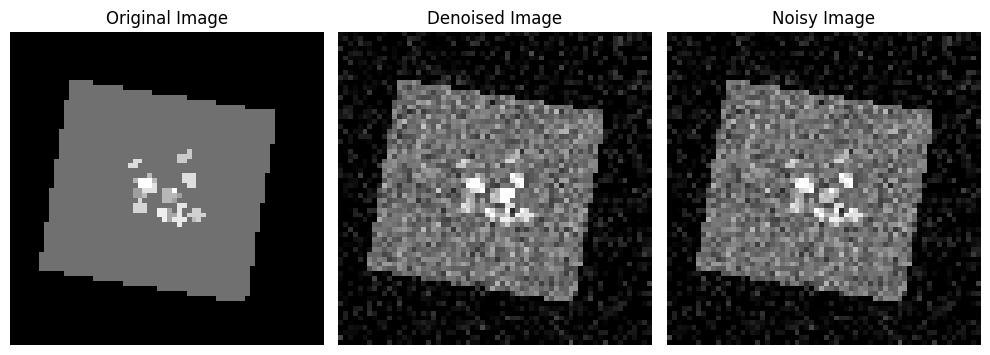

In [12]:
generic_early_stopping = EarlyStopping(
    monitor="loss", 
    mode="min", 
    patience=10, 
    verbose=True
    )

custom_early_stopping = MyEarlyStopping(
    monitor="psnr", 
    mode="max", 
    patience=25, 
    verbose=True,
    min_delta=0.1
    )

phantom = generate_phantom(resolution=6)

# model = SimpleAutoencoder()
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=64, pretrained=False)

# Create the lightning module
module = SimpleLightningEval(model, phantom=phantom)

# Create a PyTorch Lightning trainer
# trainer = Trainer(max_epochs=3)
trainer = Trainer(callbacks=[custom_early_stopping], max_epochs=25)

# # Train the model
torch.set_float32_matmul_precision('medium')  # 'medium' precesion implies high speed; 'high' precision implies high accuracy (but lower speed)
trainer.fit(module)

# ms search

In [30]:
import nni
import torch
import nni.retiarii.strategy as strategy
import nni.retiarii.nn.pytorch as nn

from collections import OrderedDict
from nni.experiment import Experiment
from nni.retiarii.evaluator import FunctionalEvaluator
from nni.retiarii.experiment.pytorch import RetiariiExperiment, RetiariiExeConfig

from nni.retiarii import model_wrapper

In [31]:
@model_wrapper
class SimpleAutoencoderSpace(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

        out_layers = OrderedDict(
            [
            ("RelU", nn.Sequential(
                nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),
                nn.ReLU())),
            
            ("Sigmoid", nn.Sequential(
                nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid())),
            ("SiLU",  nn.Sequential(
                nn.ConvTranspose2d(1, 1, 3, stride=2, padding=1, output_padding=1),
                nn.SiLU())),
            ]
        )

        self.out = nn.LayerChoice(out_layers,label='out')


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.out(x)
        return x

In [35]:
# Create the phantom
phantom = generate_phantom(resolution=6)

# Create a search space
model_space = SimpleAutoencoderSpace()

# Create a search strategy
search_strategy = strategy.Random(dedup=True)

# Create a search algorithm
module = SimpleLightningEval(model_space, phantom=phantom)

# Create an Evaluator
evaluator = FunctionalEvaluator(module)

# Create a PyTorch Lightning trainer
# trainer = Trainer(max_epochs=3)
# # trainer = Trainer(callbacks=[early_stopping], max_epochs=25)

# experiment
exp = RetiariiExperiment(model_space, evaluator, [], search_strategy)
exp_config = RetiariiExeConfig('local')
exp_config.experiment_name = 'mnist_search'
exp_config.trial_code_directory = 'C:/Users/Public/Public_VS_Code/NAS_test'
exp_config.experiment_working_directory = 'C:/Users/Public/nni-experiments'

exp_config.max_trial_number = 250   # spawn 50 trials at most
exp_config.trial_concurrency = 2  # will run two trials concurrently

exp_config.trial_gpu_number = 1 # will run 1 trial(s) concurrently
exp_config.training_service.use_active_gpu = True


# Execute
exp.run(exp_config, 8081)

[2023-08-17 00:04:48] Creating experiment, Experiment ID: mnxrt1kv
[2023-08-17 00:04:48] Starting web server...
[2023-08-17 00:04:49] Setting up...
[2023-08-17 00:04:49] Web portal URLs: http://169.254.138.100:8081 http://169.254.67.161:8081 http://169.254.50.13:8081 http://10.0.0.172:8081 http://127.0.0.1:8081
[2023-08-17 00:04:49] Dispatcher started


PayloadTooLarge: Pickle too large when trying to dump SimpleLightningEval(
  (net): SimpleAutoencoderSpace(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (3): ReLU()
      (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (5): Sigmoid()
    )
    (out): LayerChoice(OrderedDict([('RelU', Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
    )), ('Sigmoid', Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): Sigmoid()
    )), ('SiLU', Sequential(
      (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): SiLU()
    ))]), label='out')
  )
  (criterion): MSELoss()
). This might be caused by classes that are not decorated by @nni.trace. Another option is to force bytes pickling and try to raise pickle_size_limit.

In [36]:
experiment = Experiment.connect(8081)
experiment.stop()

[2023-08-17 00:05:01] Connect to port 8081 success, experiment id is mnxrt1kv, status is ERROR.
[2023-08-17 00:05:01] Stopping experiment, please wait...
[2023-08-17 00:05:01] Experiment stopped


[2023-08-17 00:05:01] Dispatcher exiting...
[2023-08-17 00:05:01] Dispatcher terminiated
